# Anomaly Detection with classifier guidance

This tutorial illustrates how to use MONAI for training a 2D gradient-guided anomaly detection using DDIMs [1].


[1] - Wolleb et al. "Diffusion Models for Medical Anomaly Detection" https://arxiv.org/abs/2203.04306


TODO: Add Open in Colab

## Setup environment

In [1]:
!python /home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/setup.py install
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

running install
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
reading manifest file 'generative.egg-info/SOURCES.txt'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating buil

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time
from typing import Dict
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset, DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
torch.multiprocessing.set_sharing_strategy('file_system')
import sys
sys.path.append('/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/')
print('path', sys.path)

from generative.inferers import DiffusionInferer


# TODO: Add right import reference after deployed
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet, DiffusionModelEncoder

from generative.networks.schedulers.ddpm import DDPMScheduler
from generative.networks.schedulers.ddim import DDIMScheduler
print_config()

losstrain_window = viz.line(Y=torch.zeros((1)).cpu(), X=torch.zeros((1)).cpu(),
                        opts=dict(xlabel='epoch', ylabel='Loss', title='training loss'))
lossval_window = viz.line(Y=torch.zeros((1)).cpu(), X=torch.zeros((1)).cpu(),
                        opts=dict(xlabel='epoch', ylabel='Loss', title='val loss '))

train_classifier=False
train_diffusionmodel=False
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min)/ (_max - _min)
    return normalized_img

Setting up a new session...


path ['/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/tutorials/generative/classifier_guidance_anomalydetection', '/home/juliawolleb/anaconda3/envs/experiment/lib/python310.zip', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/lib-dynload', '', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/PyYAML-6.0-py3.10-linux-x86_64.egg', '/home/juliawolleb/PycharmProjects/Python_Tutorials/Calgary_Infants/calgary/HD-BET', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/lpips-0.1.4-py3.10.egg', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/tqdm-4.64.1-py3.10.egg', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/generative-0.1.0-py3.10.egg', '/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/']
MONAI version: 1.1.dev2248
Numpy ver

## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir='/home/juliawolleb/PycharmProjects/MONAI/brats'  #path to where the data is stored

## Set deterministic training for reproducibility

In [5]:
set_determinism(36)

## Setup BRATS Dataset for 2D slices  and training and validation dataloaders
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150

In [29]:


channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)
print('download training set')
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print('len train data', len(train_ds))

def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1)[10:-10], 0).squeeze(-1) # we cut the lowest and highest 10 slices, because we are interested in the middle part of the brain.
    slice_label = data['slice_label']
    slice_label = torch.cat(slice_label.split(1, dim = -1)[10:-10],0).squeeze()
    return batched_2d_slices, slice_label

preprocessing_train=False
if preprocessing_train == True:
    train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
    print(f'Image shape {train_ds[0]["image"].shape}')

    data_2d_slices=[]
    data_slice_label = []
    check_data = first(train_loader_3D)
    for i, data in enumerate(train_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices.append(b2d)
        data_slice_label.append(slice_label2d)
    total_train_slices=torch.cat(data_2d_slices,0)
    total_train_labels=torch.cat(data_slice_label,0)

    torch.save(total_train_slices, 'total_train_slices.pt')
    torch.save(total_train_labels, 'total_train_labels.pt')

else:
    total_train_slices=torch.load('total_train_slices.pt')
    total_train_labels=torch.load('total_train_labels.pt')
    print('total slices', total_train_slices.shape)
    print('total lbaels', total_train_labels.shape)



/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


download training set
len train data 388
total slices torch.Size([17072, 1, 64, 64])
total lbaels torch.Size([17072])
download val set


## Setup BRATS Dataset for 2D slices  validation dataloader
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150

In [7]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)


preprocessing_val=False
if preprocessing_val == True:
    val_loader_3D = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)
    print(f'Image shape {val_ds[0]["image"].shape}')
    print('len val data', len(val_ds))
    data_2d_slices_val=[]
    data_slice_label_val = []
    for i, data in enumerate(val_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices_val.append(b2d)
        data_slice_label_val.append(slice_label2d)
    total_val_slices=torch.cat(data_2d_slices_val,0)
    total_val_labels=torch.cat(data_slice_label_val,0)
    torch.save(total_val_slices, 'total_val_slices.pt')
    torch.save(total_val_labels, 'total_val_labels.pt')

else:
    total_val_slices=torch.load('total_val_slices.pt')
    total_val_labels=torch.load('total_val_labels.pt')
    print('total slices', total_val_slices.shape)
    print('total lbaels', total_val_labels.shape)

total slices torch.Size([4224, 1, 64, 64])
total lbaels torch.Size([4224])


Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.



### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 3rd level, each with 1 attention head (`num_head_channels=64`).


In [8]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
  #  cross_attention_dim=1,
)
model.to(device)

scheduler = DDIMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training of the Diffusion Model
Here, we are training our diffusion model for 75 epochs (training time: ~50 minutes).

In [9]:
n_epochs =75
batch_size=32
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []
train_diffusionmodel=False
if train_diffusionmodel==False:
    model.load_state_dict(torch.load("./diffusion_model.pt", map_location={'cuda:0': 'cpu'}))
else:
    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))  #shuffle training data new
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))

        subset_2D_val = zip(total_val_slices.split(1), total_val_labels.split(1))  #

        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes), ncols=10)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, (a,b) in progress_bar:
            images = a.to(device)
            classes = b.to(device)
            optimizer.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)  #remove the class conditioning

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if step%20==0:
                print('step', step, loss)

            epoch_loss += loss.item()

            progress_bar.set_postfix(
                {
                    "loss": epoch_loss / (step + 1),
                }
            )
        epoch_loss_list.append(epoch_loss / (step + 1))


        if (epoch) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar.set_description(f"Epoch {epoch}")
            for    step, (a, b) in progress_bar_val:
                images = a.to(device)
                classes = b.to(device)

                timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

    total_time = time.time() - total_start
    torch.save(model.state_dict(), "./diffusion_model.pt")  #save the trained model

    print(f"train diffusion completed, total time: {total_time}.")

    plt.style.use("seaborn-bright")
    plt.title("Learning Curves Diffusion Model", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()



### Model training of the Classification Model
#First, we define the classification model. It follows the encoder architecture of the diffusion model, combined with linear layers for binary classification between healthy and diseased slices.
#Here, we are training our binary classification model for 20 epochs.

In [33]:


classifier = DiffusionModelEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    num_channels=(32,64,128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
classifier.to(device)
batch_size=32

Epoch 0: : 534it [00:29, 18.32it/s, loss=0.576]                                 


final step train 533


Epoch 0: : 132it [00:02, 56.95it/s, val_loss=0.305]


final step val 131


Epoch 1: : 534it [00:29, 18.34it/s, loss=0.576]                                 


final step train 533


Epoch 1: : 132it [00:02, 56.37it/s, val_loss=0.315]


final step val 131


Epoch 2: : 534it [00:31, 16.99it/s, loss=0.573]                                 


final step train 533


Epoch 2: : 132it [00:02, 52.98it/s, val_loss=0.312]


final step val 131


Epoch 3: : 534it [00:31, 17.21it/s, loss=0.572]                                 


final step train 533


Epoch 3: : 132it [00:02, 53.04it/s, val_loss=0.334]


final step val 131


Epoch 4: : 534it [00:31, 17.16it/s, loss=0.569]                                 


final step train 533


Epoch 4: : 132it [00:02, 52.93it/s, val_loss=0.36] 


final step val 131
train completed, total time: 167.07577848434448.
epl 5


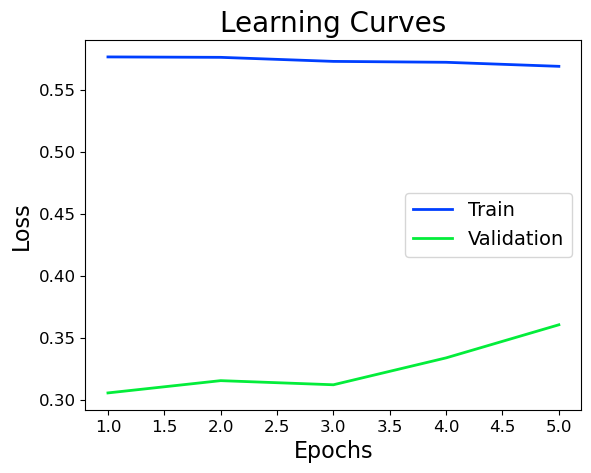

In [35]:
n_epochs = 5
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []
optimizer_cls = torch.optim.Adam(params=classifier.parameters(),  lr=2.5e-5)

classifier.to(device)

train_classifier=False
if train_classifier==False:
    classifier.load_state_dict(torch.load("./classifier5.pt", map_location={'cuda:0': 'cpu'}))
else:

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        classifier.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))
        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes)/batch_size)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (a,b) in progress_bar:
            images = a.to(device)
            classes = b.to(device)
            weight=torch.tensor((3,1)).float().to(device) #account for the class imbalance in the dataset
            optimizer_cls.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)

            with autocast(enabled=False):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Get model prediction
                noisy_img=scheduler.add_noise(images,noise, timesteps )   #add t steps of noise to the input image
                pred=classifier(noisy_img, timesteps)
                loss = F.cross_entropy(pred, classes.long(), weight=weight, reduction="mean")

            loss.backward()
            optimizer_cls.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(
                    {
                        "loss": epoch_loss / (step + 1),
                    }
                )
        epoch_loss_list.append(epoch_loss / (step + 1))
        print('final step train', step)


        if (epoch + 1) % val_interval == 0:
            classifier.eval()
            val_epoch_loss = 0
            subset_2D_val = zip(total_val_slices.split(batch_size), total_val_labels.split(batch_size))  #
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar_val.set_description(f"Epoch {epoch}")
            for step, (a,b) in progress_bar_val:
                images = a.to(device)
                classes = b.to(device)
                timesteps = torch.randint(0, 1, (len(images),)).to(device)  #check validation accuracy on the original images, i.e., do not add noise

                with torch.no_grad():
                    with autocast(enabled=False):
                        noise = torch.randn_like(images).to(device)
                        pred = classifier(images, timesteps)
                        val_loss = F.cross_entropy(pred, classes.long(), reduction="mean")

                val_epoch_loss += val_loss.item()
                _, predicted = torch.max(pred, 1);
                progress_bar_val.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))
            print('final step val', step)


    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")
    torch.save(classifier.state_dict(), "./classifier5.pt")
    
    ## Learning curves for the Classifier
    
    plt.style.use("seaborn-bright")
    plt.title("Learning Curves", fontsize=20)
    print('epl', len(epoch_loss_list))
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

### For Image-to-Image Translation to a Healthy Subject, we pick a disesed subject of the validation set

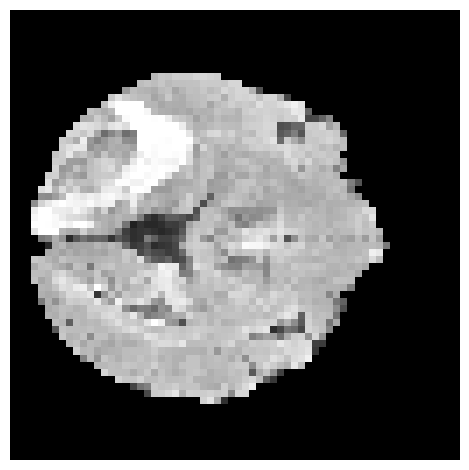

DiffusionModelEncoder(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (o

In [36]:


inputimg = total_val_slices[100][0,...]  # Pick an input slice to be transformed
inputlabel= total_val_labels[100]        # Check whether it is healthy or diseased

plt.figure("input"+str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval()
classifier.eval()

### Encoding the input image in noise with the reversed DDIM sampling scheme
In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.
We define the number of steps in the noising and denoising process by L.


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.06it/s]


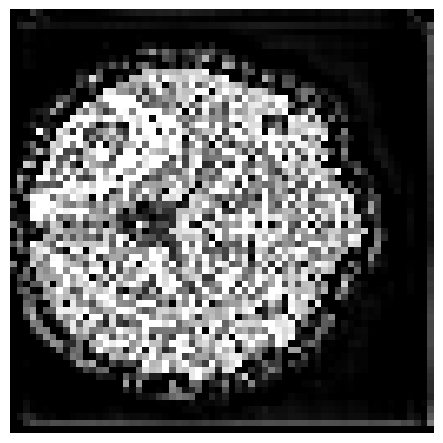

In [37]:
L=100
current_img = inputimg[None,None,...].to(device)
scheduler.set_timesteps(num_inference_steps=1000)


progress_bar = tqdm(range(L))   #go back and forth L timesteps
for t in progress_bar:  #go through the noising process

    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device))
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


### Denoising Process using gradient guidance
From the noisy image, we apply DDIM sampling scheme for denoising for L steps.
Additionally, we apply gradient guidance using the classifier network towards the desired class label y=0 (healthy). The scale s is used to amplify the gradient.

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.41it/s]


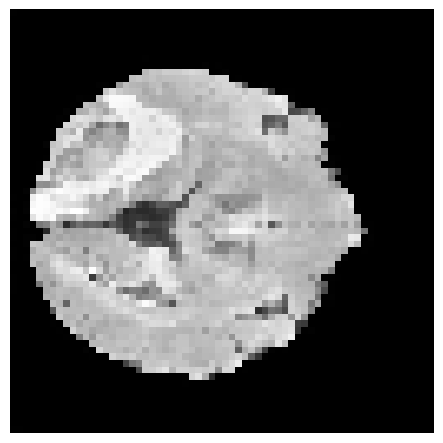

In [38]:


y=torch.tensor(0)  #define the desired class label
scale=10            #define the desired gradient scale s
progress_bar = tqdm(range(L))   #go back and forth L timesteps

for i in progress_bar:  #go through the denoising process

    t=L-i
    with autocast(enabled=True):
        model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device)) # this is supposed to be epsilon

        with torch.enable_grad():
            x_in = current_img.detach().requires_grad_(True)
            logits = classifier(x_in, timesteps=torch.Tensor((t,)).to(current_img.device))
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            a = torch.autograd.grad(selected.sum(), x_in)[0]
            alpha_prod_t = scheduler.alphas_cumprod[t]
            updated_noise = model_output- (1 - alpha_prod_t).sqrt() * scale*a  #update the predicted noise epsilon with the gradient of the classifier

    current_img, _ = scheduler.step(updated_noise, t, current_img)
    torch.cuda.empty_cache()

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()



### Anomaly Detection
To get the anomaly map, we compute the difference between the input image the output of our image-to-image translation model, which is the healthy reconstruction.

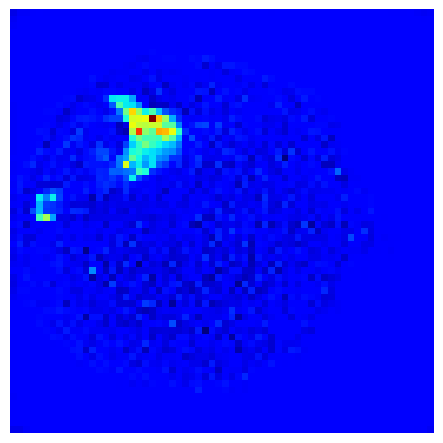

In [39]:

diff=inputimg.cpu()-current_img[0, 0].cpu().detach().numpy()
plt.style.use("default")
plt.imshow(diff, cmap="jet")
plt.tight_layout()
plt.axis("off")
plt.show()